## The Correlation Between Housing Value and the Unemployment Rates in the United States
#### Abstract
This project explores the correlation between the unemployment rate and housing value index as published by the Bureau of Labor Statistics (BLS) and Federal Housing Finance Agency (FHFA). In certain datasets, the federal government classifies the United States geographically by a five-digit Core-Based Statistical Area (CBSA) or FIPS code. Of the three-hundred-and-nintey-three geographical areas provided by the BLS and the one-hundred by the FHFA, sixty-seven CBSAs are joined. This allows us to survey some of the largest metro areas in the United States. After comparing correlation rates nationally, it is found that nationally there is a weak negative correlation between housing value and unemployment rates of -0.28. Metro Areas 




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from src.cleaning import DataCleaner    # imports my cleaning class from cleaning.py

In [2]:
# initialize data cleaner class, insert file paths to raw data sets.
data_cleaner = DataCleaner('data/raw/hpi_po_metro.csv', 'data/raw/ssamatab1.csv')

# clean unemployment data set using the DataCleaner class.
clean_unemployment_data = data_cleaner.clean_unemployment_data

# clean the housing dataset using the DataCleaner class.
clean_housing_data = data_cleaner.clean_housing_data

In [3]:
# group clean_housing_data and clean_unemployment_data by year to allow the data to be joined.
grouped_housing_data = clean_housing_data.drop(columns=['Quarter','Not_Seasonally_Adjusted_Index'] ).groupby(['CBSA', 'Metro_Name', 'Year']).agg('mean').reset_index()
grouped_unemployment_data = clean_unemployment_data.drop(columns="Month").groupby(['LAUS_Code','State_FIPS_Code','FIPS_Code','Area','Year']).agg('mean').round(2).reset_index()

# move the decimal on the Unemployment_Rate column.
grouped_unemployment_data["Unemployment_Rate"] = grouped_unemployment_data["Unemployment_Rate"] / 10

In [4]:
# make SQL database with tables "Unemployment" and "Housing_value."
with sqlite3.connect("database.db") as conn:
    grouped_unemployment_data.to_sql(
        "Unemployment", 
        conn, 
        if_exists='replace', 
        index=False
        )
    grouped_housing_data.to_sql(
        "Housing_Value", 
        conn, 
        if_exists='replace', 
        index=False
        )

In [ ]:
# SQL query that joins the two tables Unemployment and Housing_value on the CBSA/FIPS code 
tables_unemployment_and_housing_value_joined = """

SELECT 
    Unemployment.LAUS_Code,
    Unemployment.Year,
    Unemployment.Area,
    Unemployment.Employment,
    Unemployment.Unemployment,
    Unemployment.Unemployment_Rate,
    Housing_Value.Metro_Name,
    Housing_Value.Seasonally_Adjusted_Index
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
;
    
"""
# saves the query as a dataframe.
tables_unemployment_and_housing_value_joined_result = pd.read_sql(tables_unemployment_and_housing_value_joined, conn)

,LAUS_Code,Year,Area,Employment,Unemployment,Unemployment_Rate,Metro_Name,Seasonally_Adjusted_Index
0,MT0113820000000,1991,"Birmingham, AL MSA",434690.08,27664.33,5.975,"Birmingham, AL",101.3800
1,MT0113820000000,1992,"Birmingham, AL MSA",441034.00,30536.08,6.475,"Birmingham, AL",106.0900
2,MT0113820000000,1993,"Birmingham, AL MSA",449037.92,28025.17,5.858,"Birmingham, AL",111.7600
3,MT0113820000000,1994,"Birmingham, AL MSA",464502.50,22818.42,4.683,"Birmingham, AL",118.6525
4,MT0113820000000,1995,"Birmingham, AL MSA",476256.33,21285.17,4.275,"Birmingham, AL",123.9525
...,...,...,...,...,...,...,...,...
2337,MT5533340000000,2021,"Milwaukee-Waukesha, WI MSA",776365.00,35707.83,4.400,"Milwaukee-Waukesha, WI",322.5025
2338,MT5533340000000,2022,"Milwaukee-Waukesha, WI MSA",783475.58,24354.92,3.017,"Milwaukee-Waukesha, WI",357.3625
2339,MT5533340000000,2023,"Milwaukee-Waukesha, WI MSA",791676.58,24493.33,3.008,"Milwaukee-Waukesha, WI",385.8775
2340,MT5533340000000,2024,"Milwaukee-Waukesha, WI MSA",794751.75,26414.00,3.217,"Milwaukee-Waukesha, WI",415.7175


In [6]:
# group the combined table by area, returning the metro name, unemployment rate, and seasonally adjusted index.
tables_unemployment_and_housing_value_joined_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"])[["Unemployment_Rate", "Seasonally_Adjusted_Index"]].mean().round(2).reset_index()

# find the correlation by area.
correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(lambda x: x["Unemployment_Rate"].corr(x["Seasonally_Adjusted_Index"]).round(2)).rename("Correlation").reset_index()

/var/folders/x8/xnz6xf_x07z_kh3c75znshbc0000gn/T/ipykernel_3224/328213207.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table_grouped_by_area = tables_unemployment_and_housing_value_joined_result.groupby(["Metro_Name"]).apply(lambda x: x["Unemployment_Rate"].corr(x["Seasonally_Adjusted_Index"]).round(2)).rename("Correlation").reset_index()


In [7]:
# inserts these two dataframes into database.db.
with sqlite3.connect("database.db") as conn:
    tables_unemployment_and_housing_value_joined_grouped_by_area.to_sql(
        name="Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area",
        con=conn, 
        if_exists="replace"
        )
    correlations_table_grouped_by_area.to_sql(
        name="Correlations_by_Metro_Area",
        con=conn,
        if_exists="replace"
        )

In [19]:
tables_unemployment_and_housing_value_joined_grouped_by_area

,Metro_Name,Unemployment_Rate,Seasonally_Adjusted_Index
0,"Albany-Schenectady-Troy, NY",4.64,164.90
1,"Albuquerque, NM",5.27,207.30
2,"Allentown-Bethlehem-Easton, PA-NJ",5.71,166.28
3,"Austin-Round Rock-San Marcos, TX",4.19,315.16
4,"Bakersfield-Delano, CA",10.99,167.37
...,...,...,...
62,"Stockton-Lodi, CA",9.92,179.95
63,"Tucson, AZ",4.98,234.92
64,"Tulsa, OK",4.43,193.00
65,"Virginia Beach-Chesapeake-Norfolk, VA-NC",4.56,211.40


In [8]:
# SQL query to merge the tables "Unemployment_Rate_and_SAI_by_Metro_Area and Correlations_by_Metro_Area."
unemployment_rate_and_seasonally_adusted_index_joined_to_correlations = """

SELECT
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Unemployment_Rate,
    Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Seasonally_Adjusted_Index,
    Correlations_by_Metro_Area.Correlation
FROM Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area
INNER JOIN Correlations_by_Metro_Area
    ON Unemployment_Rate_and_Seasonally_Adusted_Index_by_Metro_Area.Metro_Name = Correlations_by_Metro_Area.Metro_Name
ORDER BY Correlations_by_Metro_Area.Correlation DESC
;

"""
# saves SQL query as a dataframe.
unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result = pd.read_sql(unemployment_rate_and_seasonally_adusted_index_joined_to_correlations, conn)

In [9]:
# SQL query that joins Unemployment and Housing_Value on the Metro_Name and filters by four specific metro areas.
four_metros_query = """

SELECT
    Unemployment.Year,
    Unemployment.Employment,
    Unemployment.Unemployment,
    ROUND(Unemployment.Unemployment_Rate, 2) AS Unemployment_Rate,
    Housing_Value.Metro_Name,
    ROUND(Housing_Value.Seasonally_Adjusted_Index, 2) AS Housing_Value_SAI
FROM Unemployment
INNER JOIN Housing_Value
    ON Unemployment.FIPS_Code = Housing_Value.CBSA
    AND Unemployment.Year = Housing_Value.Year
WHERE Housing_Value.Metro_Name 
    IN (
        "Fresno, CA", 
        "Des Moines-West Des Moines, IA",
        "Tulsa, OK",
        "Louisville/Jefferson County, KY-IN"
    )
;

"""

# saves the SQL to a pandas dataframe
four_metros_query_result = pd.read_sql(four_metros_query, conn)

## Weak National Correlation Between Unemployment and Housing Value
Data ranges from 1990 - 2025 and covers a significant sampling of the United States.

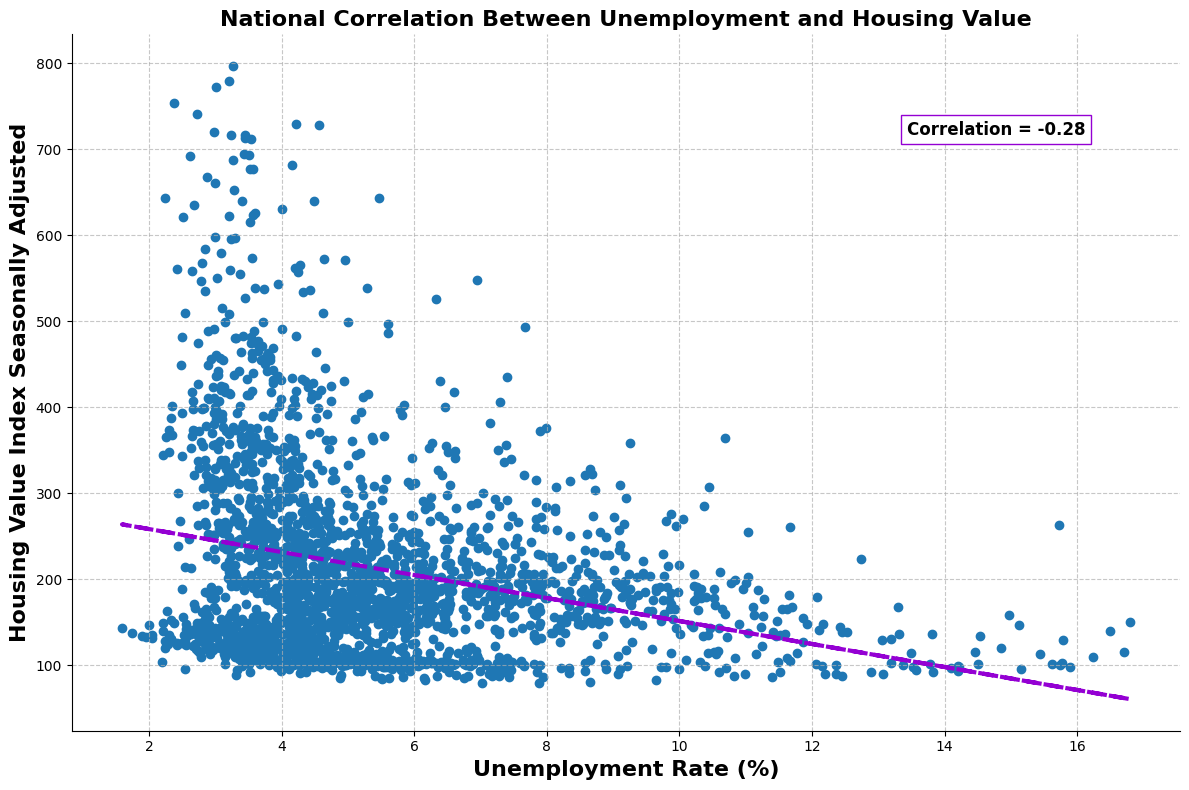

In [10]:
# scatter plot finds the national correlation between the housing value index and the unemployment rate.
x = tables_unemployment_and_housing_value_joined_result['Unemployment_Rate']
y = tables_unemployment_and_housing_value_joined_result['Seasonally_Adjusted_Index']

correlation = x.corr(y).round(2)
slope, intercept = np.polyfit(x, y, 1)      # np.polyfit calculates the slope and intercept for the y_fit
y_fit = (slope * x) + intercept             # y_fit used to plot the y axis for the correlation line

fig, ax = plt.subplots(figsize=(12,8))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Unemployment Rate (%)", fontweight='bold', fontsize=16)
ax.set_ylabel("Housing Value Index Seasonally Adjusted",fontweight='bold', fontsize=16)
ax.set_title("National Correlation Between Unemployment and Housing Value", fontweight='bold', fontsize=16)
ax.grid(True, linestyle='--', alpha=0.7)    # places a grid for easier estimatiion of the x/y value of a particular plot point.
ax.plot(x, y_fit, color="darkviolet", linewidth=3, linestyle="--")  # plots the line of correlation.

# places a box in the upper righthand corner of the plot to show the national correlation value.
ax.text(
    x.max() * 0.80,
    y.max() * 0.90, 
    f'Correlation = {correlation}',
    fontweight="bold", 
    fontsize=12,
    bbox={'facecolor': 'white', 'edgecolor': 'darkviolet'}
    )

ax.scatter(x,y) # instantiate the scatter plot.
plt.tight_layout()
plt.show()

# Is the Negative Correlation Stronger in Certain Metro Areas?

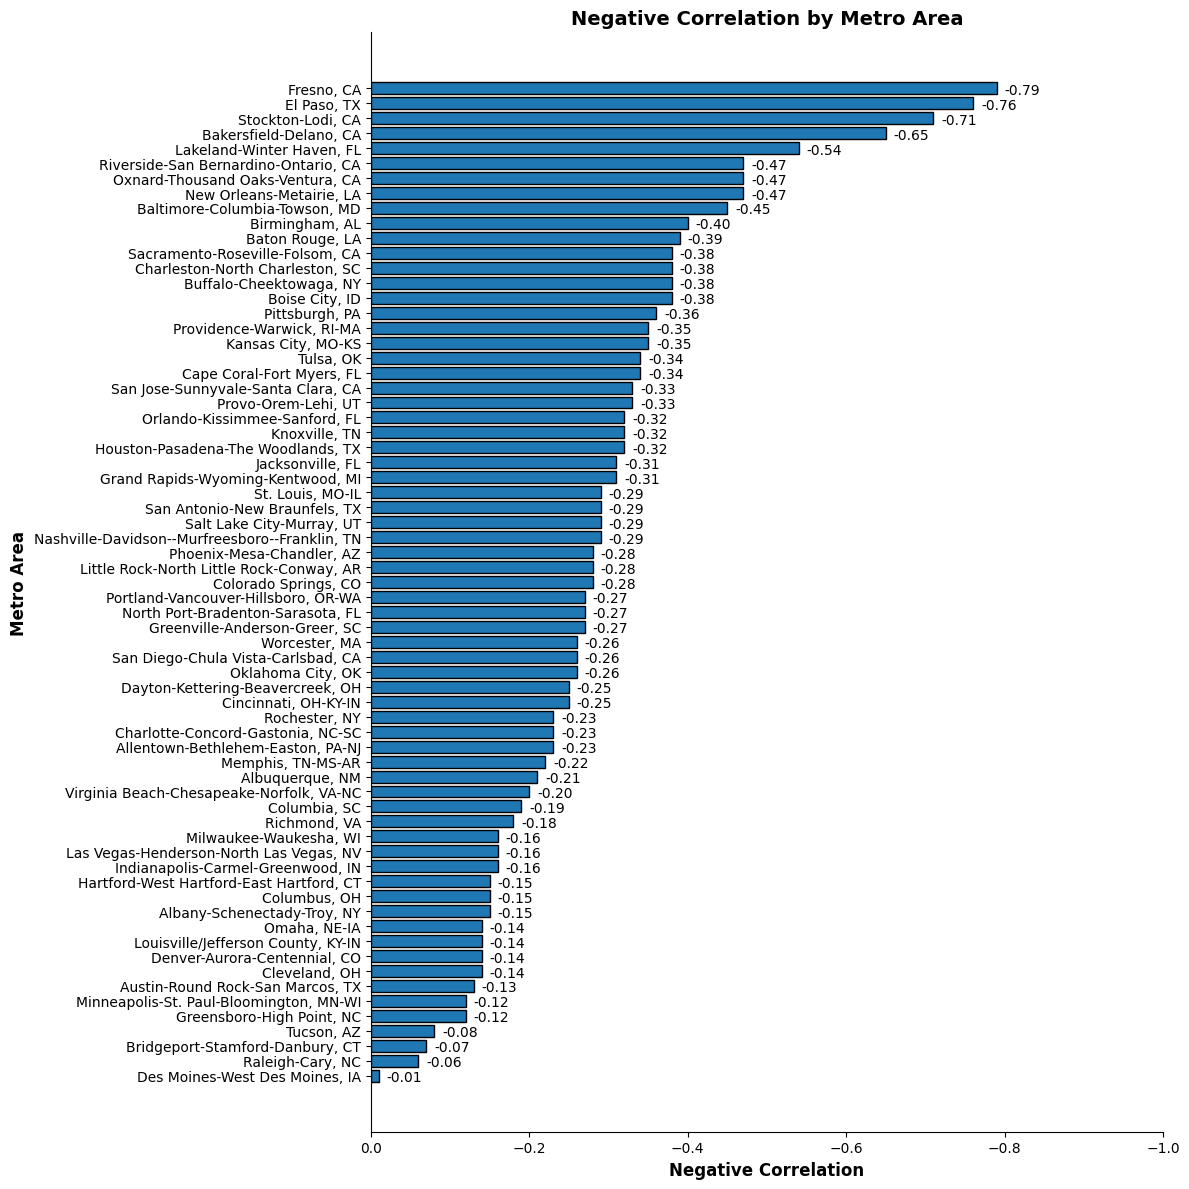

In [11]:
x = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Metro_Name"]
y = unemployment_rate_and_seasonally_adusted_index_joined_to_correlations_result["Correlation"]

fig, ax = plt.subplots(figsize=(12,12))

# set the title, spine visibility, and axis labels
ax.set_title("Negative Correlation by Metro Area", fontweight="bold", fontsize=14)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xlabel("Negative Correlation", fontweight="bold", fontsize=12)
ax.set_ylabel("Metro Area", fontweight="bold", fontsize=12)
ax.set_xlim(0, -1)

# plot as a horizontal bar chart
bars = plt.barh(x,y, edgecolor="black")

# Used a for loop to get the correlation values and place them just to the right of the bar. 
for bar in bars:
    value = bar.get_width()
    ax.text(x=value - 0.01, y=(bar.get_y() + bar.get_height() - 0.50),s=f'{value:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Time Series Analysis of Four Metro Areas

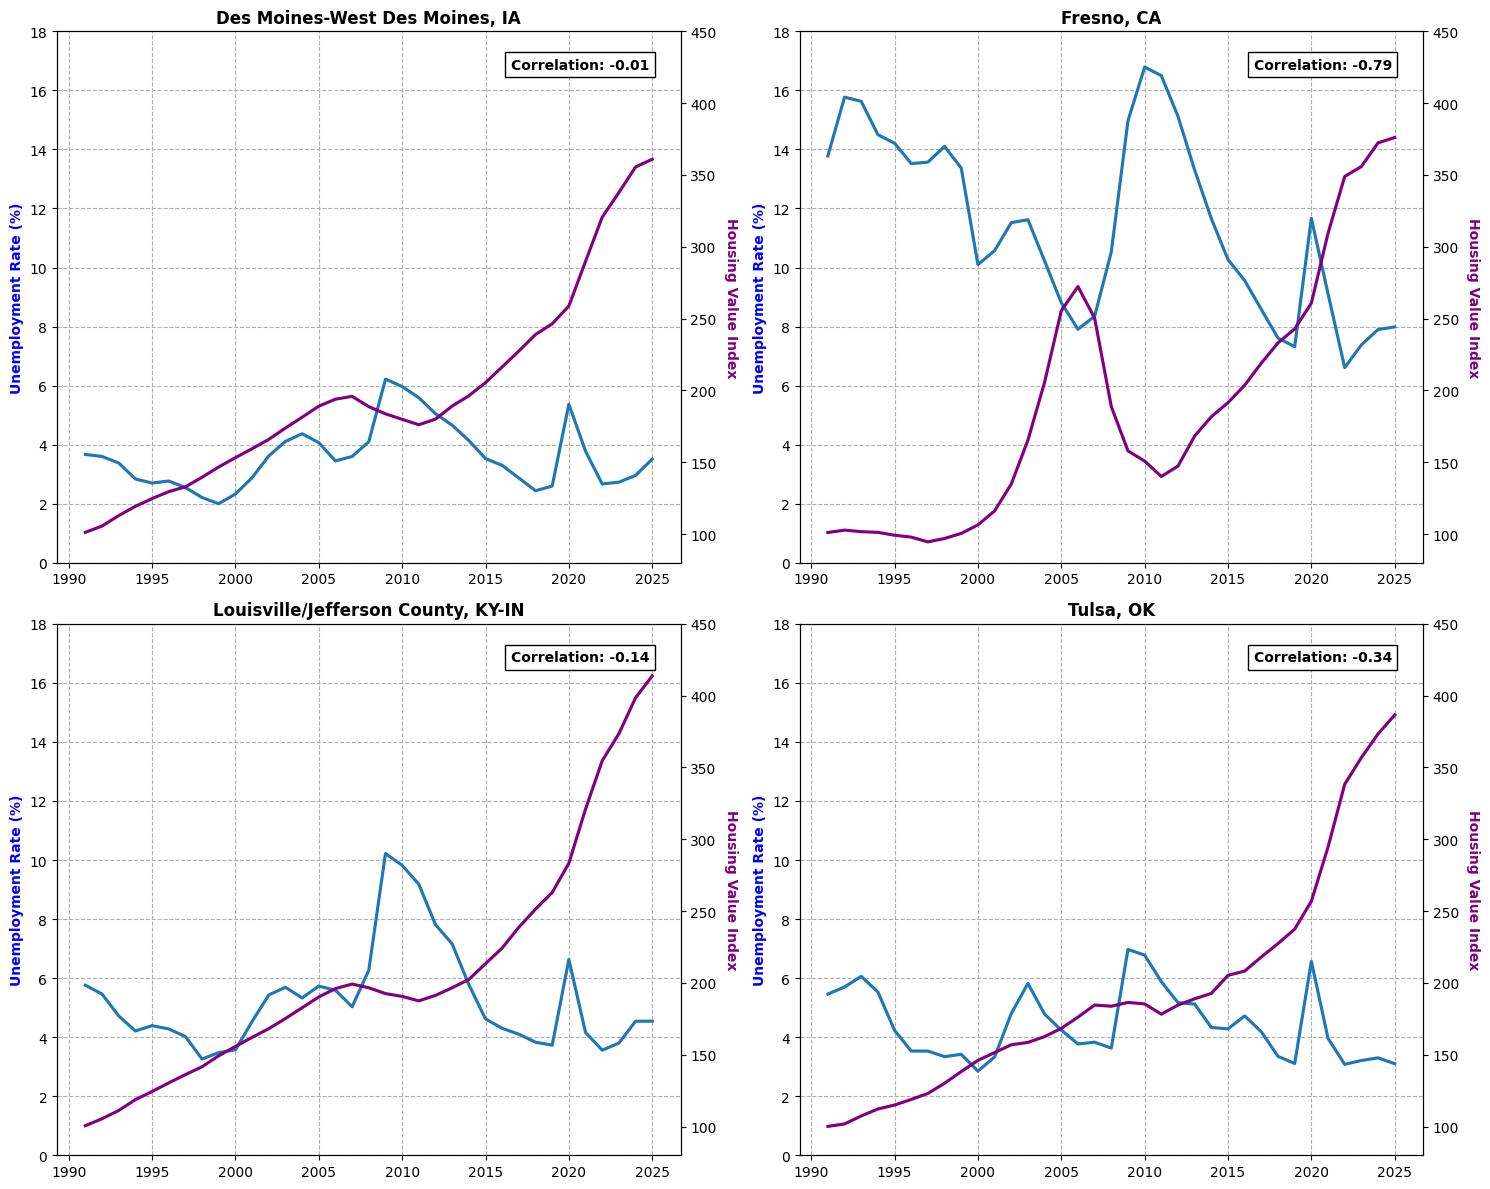

In [12]:
# create four subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

ax = ax.flatten()   # flatten to 1-D list for looping

metro_names = four_metros_query_result["Metro_Name"].unique()   # find the unique city names and save in a list

# for loop to plot each 
for metro, ax in zip(metro_names, ax):
    metro_data = four_metros_query_result[four_metros_query_result["Metro_Name"] == metro]
    
    correlation = metro_data["Unemployment_Rate"].corr(metro_data["Housing_Value_SAI"]).round(2)     # calculate the correlation for the title
    
    # plot the left axis, which is the unemployment rate.
    ax.plot(
        metro_data["Year"],
        metro_data["Unemployment_Rate"],
        linewidth=2.25
        )
   
    ax.set_ylabel("Unemployment Rate (%)", fontweight="bold", fontsize=10, color="blue")  # give the left axis a name.
    ax.set_title(f"{metro}", fontweight="bold")
    ax.set_ylim(0,18)
    ax.grid(True, linestyle='--')   # adds a grid to the background of the plots for easier placing of the line values.
    # ax.text adds a box in the upper right-hand corner of each plot with the global correlation of each metro area.
    ax.text(
        x=0.95,
        y=0.95,
        s=f"Correlation: {correlation}",
        fontweight="bold",
        fontsize=10,
        ha="right",
        va="top",
        bbox={'facecolor' : 'white'},
        transform=ax.transAxes      # transforms the coordinate system to be relative to the current subplot.
        ) 
    
    # plot the right axis, which is the housing value index. 
    ax2 = ax.twinx() # plots a second y axis on the righthand side of the plot, sharing an x axis.
    ax2.plot(
        metro_data["Year"],
        metro_data["Housing_Value_SAI"],
        color='purple',
        linewidth=2.25
        )
    ax2.set_ylabel("Housing Value Index", fontweight="bold", rotation=270, labelpad=15, fontsize=10, color="purple")
    ax2.set_ylim(80,450)
    
plt.tight_layout()    
plt.show()